In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import torch

In [3]:
PATH = '/content/drive/Shareddrives/STUDENT-EECS448Team1/rideshare2019/'

**Data Loading and Preprocessing**

In [4]:
# Read data in from parquet files. We will be pulling in rideshare data from February to December,
# and keeping 5% of all data points with nonzero tips. We will then combine the data from all of these
# months into one dataframe.

dfs = []

for i in range(2, 13):
  df = pd.read_parquet(PATH + '/fhvhv_tripdata_2019-' + str(i) + '.parquet')
  df = df[df.tips > 0]
  df = df.sample(frac = 0.05, replace = False)
  dfs.append(df)

rideshare_df = pd.concat(dfs, axis = 0)

In [5]:
rideshare_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
9422252,HV0003,B02878,B02878,2019-02-14 04:58:16,2019-02-14 04:58:24,2019-02-14 04:59:48,2019-02-14 05:10:14,236,186,3.33,...,1.14,2.75,None,4.00,12.82,N,N,N,N,None
2736150,HV0004,B02800,None,2019-02-04 12:38:18,NaT,2019-02-04 12:44:29,2019-02-04 12:55:17,144,107,1.22,...,0.47,0.75,None,0.78,0.00,Y,N,N,N,None
3052685,HV0003,B02882,B02882,2019-02-04 22:53:25,2019-02-04 22:53:32,2019-02-04 22:55:09,2019-02-04 23:09:35,158,265,3.99,...,0.00,0.00,None,3.00,38.20,N,N,N,N,None
919204,HV0005,B02510,None,2019-02-02 01:17:39,NaT,2019-02-02 01:23:43,2019-02-02 01:50:00,112,188,7.89,...,1.70,0.00,None,3.83,0.00,Y,Y,N,N,None
16147915,HV0005,B02510,None,2019-02-23 15:35:52,NaT,2019-02-23 15:38:46,2019-02-23 15:47:27,164,107,1.42,...,0.79,2.75,None,2.00,5.86,N,N,N,N,None
266110,HV0005,B02510,None,2019-02-01 11:22:32,NaT,2019-02-01 11:25:15,2019-02-01 11:43:20,114,246,2.43,...,0.92,0.00,None,2.00,9.53,N,Y,N,N,None
8243816,HV0003,B02864,B02864,2019-02-12 11:48:58,2019-02-12 11:54:01,2019-02-12 11:55:00,2019-02-12 12:01:13,50,142,0.54,...,1.33,2.75,None,5.00,15.61,N,N,N,N,None
14510733,HV0005,B02510,None,2019-02-21 12:26:43,NaT,2019-02-21 12:28:54,2019-02-21 12:46:06,234,90,0.75,...,0.68,2.75,None,2.00,9.33,N,N,N,N,None
1255514,HV0005,B02510,None,2019-02-02 13:57:58,NaT,2019-02-02 14:01:31,2019-02-02 14:49:52,138,163,11.06,...,2.65,0.75,None,6.11,0.00,Y,Y,N,N,None
14966780,HV0005,B02510,None,2019-02-22 01:59:49,NaT,2019-02-22 02:02:47,2019-02-22 02:15:32,158,87,3.45,...,0.80,0.75,None,2.00,0.00,Y,N,N,N,None


In [6]:
# Sometimes, there are tips that are much larger than expected. To remove these outliers,
# we keep only data points whose tips are less than the 95th percentile.

rideshare_df = rideshare_df[rideshare_df['tips'] < rideshare_df['tips'].quantile(.95)]

**Combining Weather Dataset**

In [7]:
# Now we want to read in our weather data. We do some quick preprocessing, as
# the features precipitation, new_snow, and snow_depth can have the value 'T'.
# This isn't a value we can use in our models, so we remove any datapoints that
# contain this.

weather_df = pd.read_csv('/content/drive/Shareddrives/STUDENT-EECS448Team1/nyc_temperature_2019.csv')
weather_df = weather_df[weather_df.precipitation != 'T']
weather_df = weather_df[weather_df.new_snow != 'T']
weather_df = weather_df[weather_df.snow_depth != 'T']
weather_df.reset_index(inplace = True)

In [8]:
weather_df.head(10)

,index,date,tmax,tmin,tavg,departure,HDD,CDD,precipitation,new_snow,snow_depth
0,0,1/1/19,60,40,50.0,13.9,15,0,0.08,0,0
1,1,2/1/19,41,35,38.0,2.1,27,0,0,0,0
2,3,4/1/19,47,37,42.0,6.5,23,0,0,0,0
3,4,5/1/19,47,42,44.5,9.1,20,0,0.45,0,0
4,6,7/1/19,35,26,30.5,-4.5,34,0,0,0,0
5,7,8/1/19,47,35,41.0,6.1,24,0,0.21,0,0
6,8,9/1/19,46,35,40.5,5.8,24,0,0.07,0,0
7,9,10/1/19,35,30,32.5,-2.1,32,0,0,0,0
8,10,11/1/19,32,22,27.0,-7.5,38,0,0,0,0
9,11,12/1/19,34,21,27.5,-6.9,37,0,0,0,0


In [9]:
# We need a way to merge our rideshare data and our weather data, so we will be
# creating a new column for both, 'date'. This new column will contain the date
# the datapoint was recorded as a datetime object. This way, we can merge the weather
# dataframe onto the rideshare dataframe through this new column, and for every 
# rideshare data point the appropriate weather data will be appended.

import datetime

weather_df['day_of_week'] = weather_df['date']

for j, date in enumerate(weather_df['date']):
  slashes = [i for i in range(len(date)) if date[i] == '/']
  day = int(weather_df['date'][j][0:slashes[0]])
  month = int(weather_df['date'][j][slashes[0]+1:slashes[1]])
  if not isinstance(date, datetime.date):
    weather_df['date'][j] = pd.Timestamp(datetime.date(2019, month, day)).date()
  weather_df['day_of_week'][j] = datetime.date(2019, month, day).isoweekday()

ridshare_df = rideshare_df.reset_index()
rideshare_df['date'] = rideshare_df['pickup_datetime']

for k, date in enumerate(rideshare_df['date']):
  rideshare_df['date'].iloc[k] = rideshare_df['date'].iloc[k].date()

<ipython-input-9-9a856f441b55>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['day_of_week'][j] = datetime.date(2019, month, day).isoweekday()
<ipython-input-9-9a856f441b55>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['date'][j] = pd.Timestamp(datetime.date(2019, month, day)).date()
<ipython-input-9-9a856f441b55>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rideshare_df['date'].iloc[k] = rideshare_df

In [10]:
# Merge the two dataframes together.

df = pd.merge(rideshare_df, weather_df, on="date", how="left")

len(df)

1515598

In [11]:
# Many features in the dataframe have binary 'Y' or 'N' values.
# We want to convert them to 0 and 1 so our models can learn from
# those features too.

def replace_flag_columns(df, column_name):
  df.loc[df[column_name] == 'Y', column_name] = 1
  df.loc[df[column_name] == 'N', column_name] = 0


replace_flag_columns(df, 'shared_request_flag')
replace_flag_columns(df, 'shared_match_flag')
replace_flag_columns(df, 'access_a_ride_flag')
replace_flag_columns(df, 'wav_request_flag')
replace_flag_columns(df, 'wav_match_flag')

In [12]:
# Create new columns so that we can keep track of the hours and
# days of a request, features that are useful unlike a datetime
# object

def extract_date_features(df, column_name):
  df[column_name + '_hour'] = df[column_name].dt.hour
  df[column_name + '_minute'] = df[column_name].dt.day

extract_date_features(df, 'request_datetime')

df.iloc[0]

hvfhs_license_num                       HV0003
dispatching_base_num                    B02878
originating_base_num                    B02878
request_datetime           2019-02-14 04:58:16
on_scene_datetime          2019-02-14 04:58:24
pickup_datetime            2019-02-14 04:59:48
dropoff_datetime           2019-02-14 05:10:14
PULocationID                               236
DOLocationID                               186
trip_miles                                3.33
trip_time                                  625
base_passenger_fare                      12.88
tolls                                      0.0
bcf                                       0.32
sales_tax                                 1.14
congestion_surcharge                      2.75
airport_fee                               None
tips                                       4.0
driver_pay                               12.82
shared_request_flag                          0
shared_match_flag                            0
access_a_ride

In [13]:
# Drop columns that are almost completely NaN values,
# along with variables that are directly affected by tip
# amount. Then, remove any rows that have a NaN value.
      
df = df.dropna(axis=1, thresh=(df.shape[0]*0.8))
df = df.drop(['driver_pay', 'bcf', 'sales_tax'], axis=1)
df = df.dropna()

print(len(df))
df.columns

1254729


Index(['hvfhs_license_num', 'dispatching_base_num', 'request_datetime',
       'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID',
       'trip_miles', 'trip_time', 'base_passenger_fare', 'tolls',
       'congestion_surcharge', 'tips', 'shared_request_flag',
       'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'date',
       'index', 'tmax', 'tmin', 'tavg', 'departure', 'HDD', 'CDD',
       'precipitation', 'new_snow', 'snow_depth', 'day_of_week',
       'request_datetime_hour', 'request_datetime_minute'],
      dtype='object')

<ipython-input-14-6ad5c82d3218>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

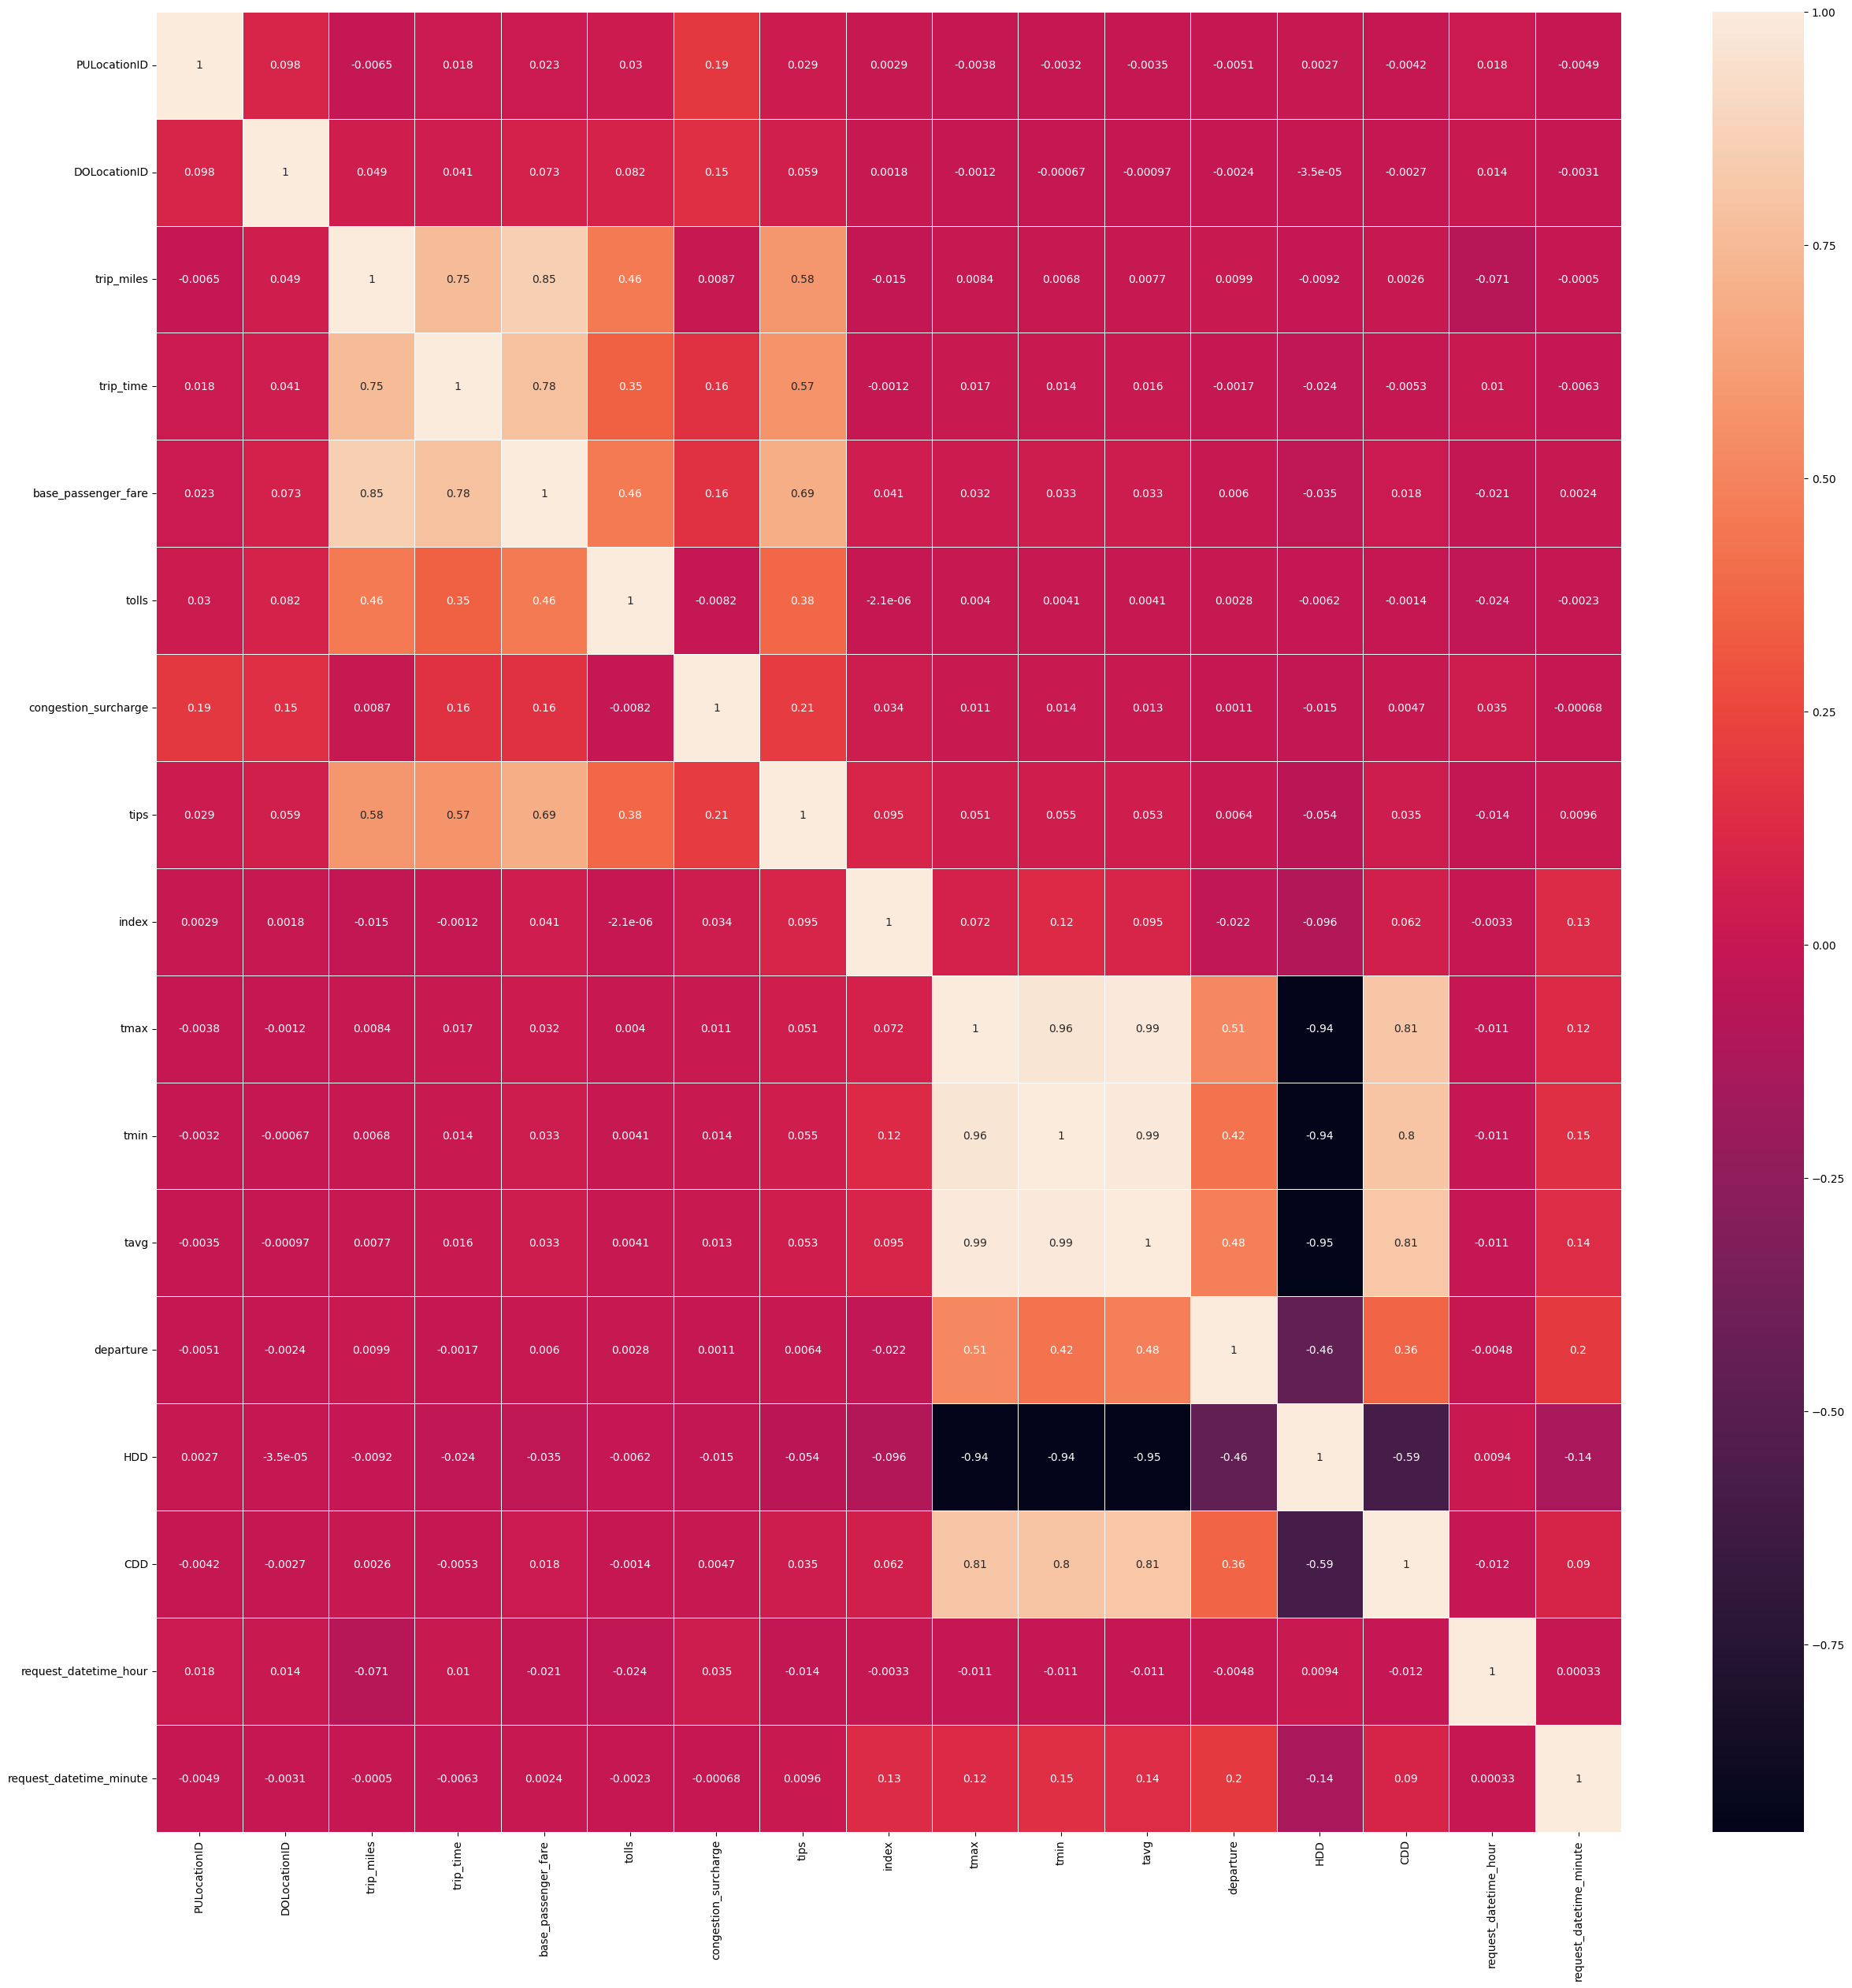

In [14]:
# Create heatmap for variables of interest

corr = df.corr()

fig, ax = plt.subplots(figsize=(30,30))
sn.heatmap(corr, annot=True, linewidths=.5, ax=ax)

**Linear Regression**

In [15]:
# Split data into training, validation, and testing splitsfrom sklearn.model_selection import train_test_split
# Also scale the input features.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['tips', 'hvfhs_license_num',	'dispatching_base_num', 'request_datetime', 'pickup_datetime', 'dropoff_datetime', 'date', 'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag'], axis=1)
y = df[['tips']]

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=20)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=20)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)



mean of test labels: tips    3.607808
dtype: float64
mean squared error if we only predict the mean: tips    6.277993
dtype: float64
mean squared error for test set: 3.1286213363323916
R^2 for test data: 0.5016526586162786

coefficients: [[-1.57115840e-02 -2.30303631e-02 -1.19322700e-02  1.68707425e-01
   1.45715648e+00  2.41870235e-01  2.59173415e-01  1.64335551e-01
  -4.06053019e+11 -3.63677246e+11  7.62734981e+11 -2.88860844e-02
   4.49880969e-01 -2.39525217e-01 -3.68950991e-03  7.88505852e-03
   7.00192862e-04  1.01354487e-02 -9.55226940e-03 -3.01259853e-03]]

mean of residuals: tips    0.001323
dtype: float64
standard deviation of residuals: tips    1.76879
dtype: float64
0.5016526586162786


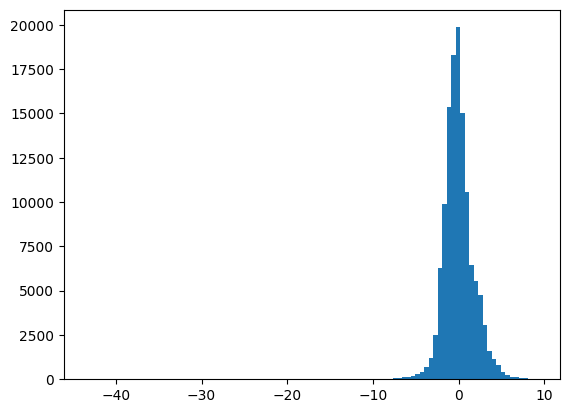

In [16]:
# Train a linear regression model, and evaluate.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

reg = LinearRegression().fit(X_train, y_train)

pred = reg.predict(X_test)
print('\nmean of test labels:', np.mean(y_test))
print('mean squared error if we only predict the mean:', np.sum((y_test - np.mean(y_test))**2)/len(y_test))
print('mean squared error for test set:', mean_squared_error(y_test, pred))
print('R^2 for test data:', r2_score(y_test, pred))

print('\ncoefficients:', reg.coef_)

residuals = y_test - pred
plt.hist(residuals, bins=100)
print('\nmean of residuals:', np.mean(residuals, axis=0))
print('standard deviation of residuals:', np.std(residuals))

print(reg.score(X_test, y_test))

**Neural Network**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [19]:
# Design our model.

model = nn.Sequential(
    nn.Linear(20, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

model.to(device)

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=1, bias=True)
)

In [20]:
# Create a data loader for our training data so we can train on batches.

class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.astype(np.float32))
        self.y = torch.from_numpy(y.values).float().to(device)
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

In [21]:
# Define our optimizer and loss function.

lr = 0.0001
weight_decay = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [22]:
# Train our neural network for 2 epochs.

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 2
loss_values = []
num_itr = 0

for epoch in range(1):
    for X, y in train_dataloader:
        num_itr += 1

        optimizer.zero_grad()
        pred = model(X.cuda())
        loss = torch.sqrt(loss_function(pred, y))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print('Epoch No. {0}--Iteration No. {1}-- batch loss = {2:.4f}'.format(
      epoch + 1,
      num_itr,
      loss.item()
      ))

print('Training process has finished.')

Epoch No. 1--Iteration No. 31369-- batch loss = 1.8797
Training process has finished.


In [23]:
# Evaluate our model's performance on the test set

pred = model(torch.tensor(X_test.astype(np.float32)).cuda())

print('MSE on validation data:', mean_squared_error(y_test, pred.cpu().detach().numpy(), squared=True))
print('R^2 of test set:', r2_score(y_test, pred.cpu().detach().numpy()))

MSE on validation data: 2.667533091977626
R^2 of test set: 0.5750978205631869


**XGB Boosting Hyper Parameter Search**

In [24]:
import xgboost as xgb
import itertools
import time

# Define hyperparameters to tune
hyperparams = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 200],
    'reg_lambda': [1, 2],
    'gamma': [0, 1]
}


combinations = list(itertools.product(*hyperparams.values()))

# Train and evaluate the XGBoost model for each hyperparameter combination
best_score = float('inf')
best_params = {}
start_time=  time.time()
for params in combinations:
    param_dict = {list(hyperparams.keys())[i]: params[i] for i in range(len(params))}

    xgb_model = xgb.XGBRegressor(**param_dict, tree_method='gpu_hist', verbose=0)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    score = mean_squared_error(y_val, y_pred)
    print("Param: ", params)
    print(time.time() - start_time)
    print(score)
    if score < best_score:
        best_score = score
        best_params = param_dict

# Train the XGBoost model using the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_params, tree_method='gpu_hist', verbose=3)
best_xgb_model.fit(X_train, y_train)
predictions = best_xgb_model.predict(X_test)

print("Best hyperparameters: ", best_params)
print("Best score: ", best_score)

[00:12:59] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Param:  (3, 0.1, 50, 1, 0)
4.452518463134766
2.6296026109736332
[00:13:02] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Param:  (3, 0.1, 50, 1, 1)
7.46801233291626
2.6296026109736332
[00:13:05] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Param:  (3, 0.1, 50, 2, 0)
10.449945449829102
2.6296077303554095
[00:13:09] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Param:  (3, 0.1, 50, 2, 1)
14.013258934020996
2.6296077303554095
[00:13:12] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Param:  (3, 0.1, 100, 1, 0)
17.737184762954712
2.611166940047617
[00:13:16] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Param:  (3, 0.1, 100, 1, 1)
20.95761227607727
2.611166940047617
[00:13:19] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Param:  (3, 0.1, 10

In [25]:
# Train the XGBoost model using the best hyperparameters
from sklearn.metrics import mean_squared_error, r2_score
best_xgb_model = xgb.XGBRegressor(**best_params, tree_method='gpu_hist', verbose=3)
best_xgb_model.fit(X_train, y_train)
predictions = best_xgb_model.predict(X_test)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", best_params)
print("Best score: ", best_score)
y_test_pred = best_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("Test MSE: ", mse)
print("Test R^2: ", r2)

[00:17:57] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Best hyperparameters:  {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 200, 'reg_lambda': 1, 'gamma': 0}
Best score:  2.5618239257126265
Test MSE:  2.559490369400231
Test R^2:  0.5923075745615478
